In [19]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

sns.set()
%matplotlib inline

endangered_languages = pd.read_csv('../data_sets/endangered_languages_ML.csv')
X = endangered_languages.drop(['Language', 'Extinct'], axis=1)
y = endangered_languages['Extinct']
print(X.shape)
print(y.shape)

(1933, 160)
(1933,)


Class 0: 1740
Class 1: 193
Proportion: 9.02 : 1


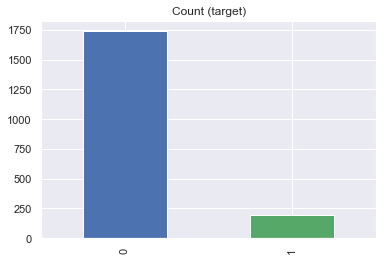

In [22]:
target_count = y.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)', color=['b', 'g']);

I know that from intimate knowledge of my dataset that my classes are imbalanced. Taking a look at the graph, we can see that the number of extinct languages is small compared to the number of non-extinct languages. Approximately a 9 to 1 imbalance. So we can do some data resampling to correct this issue before running any models on the data.

One of the major issues with this not being handled is that any simple metrics used to evaluate the model can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate.

In [23]:
# Class count
class_count_0, class_count_1 = target_count

# Divide by class
df_class_0 = y[y == 0]
df_class_1 = y[y == 1]

#### Random Under-Sampling

1    193
0    193
Name: Extinct, dtype: int64


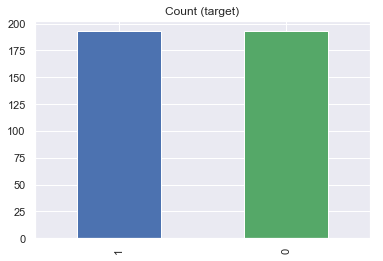

In [29]:
df_class_0_under = df_class_0.sample(class_count_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print(df_test_under.value_counts())

df_test_under.value_counts().plot(kind='bar', title='Count (target)', color=['b', 'g']);

#### Random Over-Sampling

1    1740
0    1740
Name: Extinct, dtype: int64


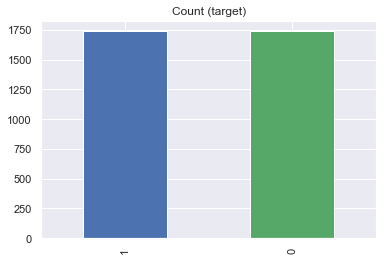

In [30]:
df_class_1_over = df_class_1.sample(class_count_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print(df_test_over.value_counts())

df_test_over.value_counts().plot(kind='bar', title='Count (target)', color=['b', 'g']);

A number of more sophisticated resampling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [10]:
log_reg = LogisticRegression(solver='lbfgs')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [42]:
log_reg.fit(X_train, y_train.values.ravel())
y_pred = log_reg.predict(X_test)

# upsample 
# duplicate extinct langaue rows
# SMOTE (has random permutations to data)
# predict_proba(with threshold adjustment away from 50%)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[523   0]
 [ 57   0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       523
           1       0.00      0.00      0.00        57

   micro avg       0.90      0.90      0.90       580
   macro avg       0.45      0.50      0.47       580
weighted avg       0.81      0.90      0.86       580



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


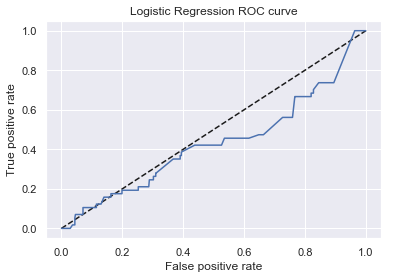

In [34]:
# ROC Curve (threshold is 0.5 for probability (this threshold defines our model), what happens when we vary threshold. 
# What happens to the true positive and false positive rates. WHen threshold = 0, the model predicts 1 for all data
# which means the true positive is equal to false positve) 0 and 1 are bad should go straight up and then right
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.show()

In [40]:
# the larger the area under the ROC curve, the better our model is
roc_auc_score(y_test, y_pred_prob)

# can also be done with cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
print(cv_scores)

[0.43918326 0.41507286 0.37425697 0.50518214 0.49992379]


In [44]:
# Hyperparameter tuning with GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(log_reg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X_train, y_train.values.ravel())

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1e-05}
Best score is 0.8994826311899483


In [ ]:
# Hold out test reasoning
# upsample all data
# random forest classification 
# knn 
# logisitic regression